In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [3]:
#### ALL PARAMETERS DEFINED HERE ####

# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Mito_live_2Dtimelapses\preselection")

# Parameters
augment = False
maxFramesPerTimelapse = 30
normGMM = False # put True if data was normalized to create the GMM
display = True # display images or not
clip = -5 # False or clip value


# Load GMM
noiseModelPath = r"E:\dl_monalisa\Data\Mito_fixed\noise_models\final\GMM_Noiseall_SigAVG_Clip0_noNorm.npz"
noise_model_params = np.load(noiseModelPath)
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)
print(f"Loaded noise model: {noiseModelPath}")

# Training prm
patch_size = 64
gaussian_noise_std = None

# Training-specific
beta = 0.022 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=1e-5
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 6
batchnorm = True
free_bits = 1.0

# Model name for saving
modelName = f"Mito_live_2Dtimelapses_GMMmito_clip{clip}_{num_latents}Lat_{blocks_per_layer}Blocks_betaKL{beta}"

save_model_basedir = "./Trained_model/" 
print(f"Trained model will be saved at: {save_model_basedir}")
print(f"Model save name: {modelName}")


Loaded noise model: E:\dl_monalisa\Data\Mito_fixed\noise_models\final\GMM_Noiseall_SigAVG_Clip0_noNorm.npz
Trained model will be saved at: ./Trained_model/
Model save name: Mito_live_2Dtimelapses_GMMmito_clip-5_5Lat_6Blocks_betaKL0.022


In [4]:
##### Load data ####
# crop_size = (1392,1392)
signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")


obs_patches = np.zeros(shape=(36400*3,patch_size,patch_size))
cumulpatchescounter = 0
for i,f in enumerate(files):
    im_obs  = imread(data_path / f)
    np.random.shuffle(im_obs)
    if im_obs.shape[0]>maxFramesPerTimelapse:
        im_obs = im_obs[:maxFramesPerTimelapse]
    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
    # im_obs = (im_obs - np.mean(im_obs) / np.std(im_obs))
    img_width = im_obs.shape[2]
    img_height = im_obs.shape[1]
    num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)
    print(f"File {f}: shape: {im_obs.shape} num_patches: {num_patches*im_obs.shape[0]}")
    obs_patches[cumulpatchescounter:cumulpatchescounter+num_patches*im_obs.shape[0]] = utils.extract_patches(im_obs, patch_size, num_patches)
    cumulpatchescounter += num_patches*im_obs.shape[0]
    print(cumulpatchescounter)

if normGMM:
    print("Normalizing data")
    obs_patches = (obs_patches - np.mean(obs_patches)) / np.std(obs_patches)
else:
    print("No normalization")



removing denoisedUNET_RCAN in signals because not in filters
Removing denoised_HDN in observations because not in filters

Found 13 files.

File 14h28m33s_rec_scan000_CAM.hdf5_multi.0.reconstruction.tif: shape: (30, 677, 892) num_patches: 4410


100%|██████████| 30/30 [00:00<00:00, 492.73it/s]

4410


File 15h05m02s_rec_scan000_CAM.hdf5_multi.0.reconstruction.tif: shape: (30, 1218, 1232) num_patches: 10980


100%|██████████| 30/30 [00:00<00:00, 191.61it/s]


15390
File 15h29.tiff: shape: (30, 626, 1026) num_patches: 4680


100%|██████████| 30/30 [00:00<00:00, 448.50it/s]

20070


File c1.tiff: shape: (30, 802, 1177) num_patches: 6900


100%|██████████| 30/30 [00:00<00:00, 296.12it/s]

26970


File c2.tiff: shape: (30, 839, 1391) num_patches: 8520


100%|██████████| 30/30 [00:00<00:00, 247.12it/s]

35490


File c3.tiff: shape: (30, 839, 1391) num_patches: 8520


100%|██████████| 30/30 [00:00<00:00, 244.51it/s]


44010
File c5.tiff: shape: (30, 840, 881) num_patches: 5400


100%|██████████| 30/30 [00:00<00:00, 395.57it/s]

49410


File c6.tiff: shape: (30, 1362, 1382) num_patches: 13770


100%|██████████| 30/30 [00:00<00:00, 149.32it/s]
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


63180
File c6_crop1.tif: shape: (30, 360, 360) num_patches: 930


100%|██████████| 30/30 [00:00<00:00, 1198.26it/s]
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


64110
File c6_crop2.tif: shape: (30, 330, 330) num_patches: 780


100%|██████████| 30/30 [00:00<00:00, 2603.76it/s]


64890
File c7.tiff: shape: (30, 1096, 1382) num_patches: 11070


100%|██████████| 30/30 [00:00<00:00, 183.28it/s]


75960
File c8.tiff: shape: (30, 1390, 1394) num_patches: 14190


100%|██████████| 30/30 [00:00<00:00, 124.53it/s]


90150
File c9.tiff: shape: (30, 1188, 972) num_patches: 8430


100%|██████████| 30/30 [00:00<00:00, 185.37it/s]


98580
No normalization


In [ ]:
# Patches extraction
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

if not supervised:
    train_images = utils.extract_patches(train_data, patch_size, num_patches)
    val_images = utils.extract_patches(val_data, patch_size, num_patches)
else:
    train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
    val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)

 # We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
test_images = val_images[:100]
if supervised:
    val_images_gt = val_images_gt [:1000] 
    test_images_gt = val_images_gt[:100]
    
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

In [ ]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised


train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images, train_images_gt, 
                                                                                                      val_images, val_images_gt,
                                                                                                      batch_size, test_batch_size,upsamp=1)


# Here we ensure that steps_per_epoch not bigger than len(train_loader)
# It never goes into validation otherwise, and so it never saves the model.
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
print(steps_per_epoch)

400


(64, 64)
(64, 64)


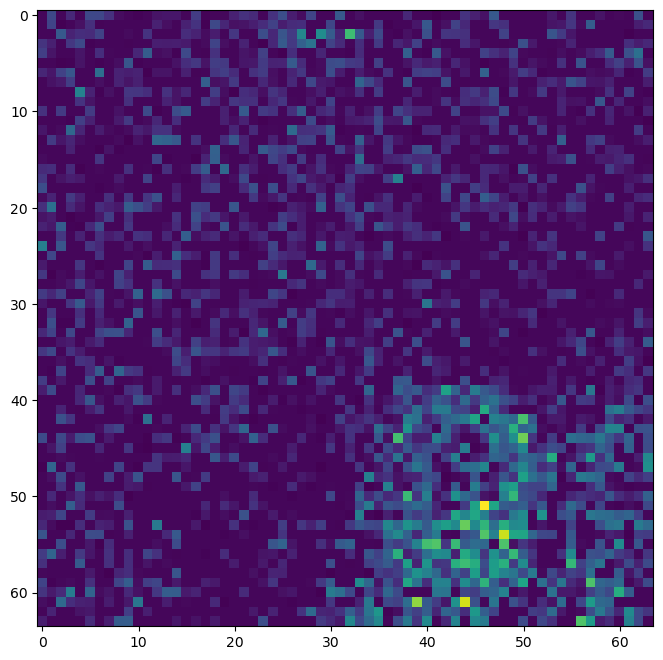

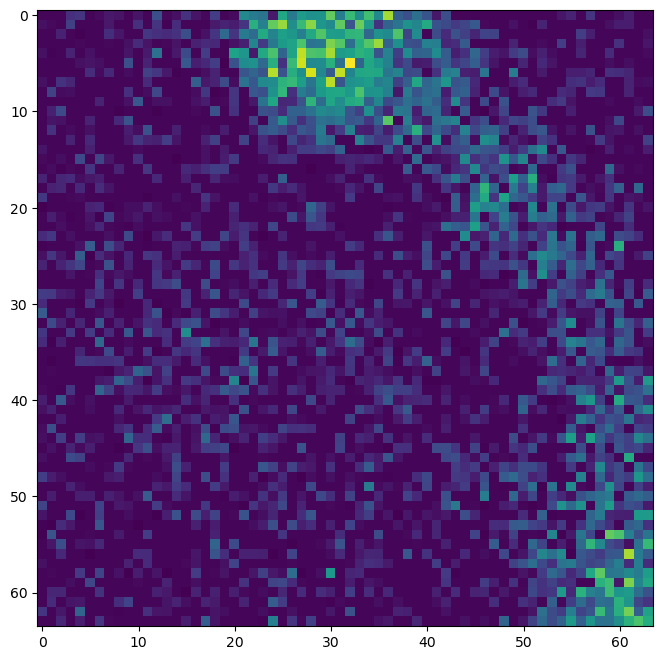

In [7]:

batch_idx, (x, y) = next(enumerate(train_loader))

x2 = x.cpu().numpy()
x2 = x2[0]
print(x2.shape)
plt.figure(figsize=(8,8))
plt.imshow(x2)

batch_idx, (x, y) = next(enumerate(val_loader))

x2 = x.cpu().numpy()
x2 = x2[0]
print(x2.shape)
plt.figure(figsize=(8,8))
plt.imshow(x2)

In [8]:
print(data_mean,data_std)

15.51015353115237 36.387341611707804


In [9]:
# Train network



model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=(64,64)).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=100,beta=beta)

Epoch[1/500] Training Loss: 4.322 Reconstruction Loss: 4.303 KL Loss: 0.838
saving ./Trained_model/model/Mito_live_2Dtimelapses_GMMmito_clip-5_5Lat_6Blocks_betaKL0.022_last_vae.net
saving ./Trained_model/model/Mito_live_2Dtimelapses_GMMmito_clip-5_5Lat_6Blocks_betaKL0.022_best_vae.net
Patience: 0 Validation Loss: 5.330172538757324 Min validation loss: 5.330172538757324
Time for epoch: 428seconds
Est remaining time: 2 days, 11:19:32 or 213572 seconds
----------------------------------------
Epoch[2/500] Training Loss: 3.968 Reconstruction Loss: 3.939 KL Loss: 1.321
saving ./Trained_model/model/Mito_live_2Dtimelapses_GMMmito_clip-5_5Lat_6Blocks_betaKL0.022_last_vae.net
saving ./Trained_model/model/Mito_live_2Dtimelapses_GMMmito_clip-5_5Lat_6Blocks_betaKL0.022_best_vae.net
Patience: 0 Validation Loss: 4.889723777770996 Min validation loss: 4.889723777770996
Time for epoch: 507seconds
Est remaining time: 2 days, 22:08:06 or 252486 seconds
----------------------------------------
Epoch[3/50

# Plotting losses

In [10]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

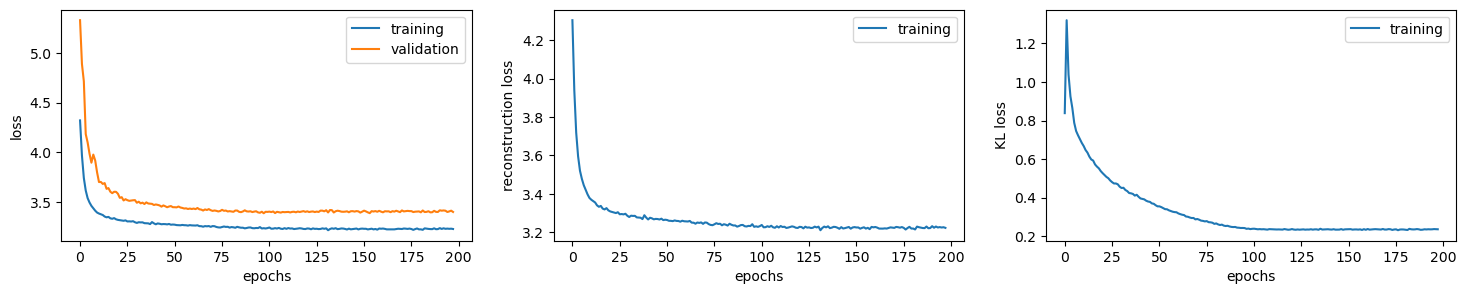

In [11]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()